# Final Report - Regression Project
Nathan Sharick - Innis Cohort

---

##### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import f_regression, SelectKBest, RFE
from scipy import stats
import os
import warnings
warnings.filterwarnings('ignore')
import math
from acquire import acquire_zillow
from prepare import prep_data
from prepare import split_data
from prepare import remove_outliers
from prepare import split_by_region

#### Acquire, Clean, Split, and Wrangle the data
- The acquire_zillow function checks for a local copy of the dataset as a .csv file and if there is not one it will pull a new copy from the CodeUp database by joining the properties_2017 and the predictions_2017 tables and pulling the columns with the selected features and rows that correspond with home sales closed in 2017 as noted in the predictions_2017 table. This query resulted in 52442 observations (rows). The acquire_zillow is located in the acompanying acquire.py file.

- Since the final acquire function was updated to only pull the selected feature columns, the overall number of rows with null values was greatly reduced and dropping all observations with incomplete data resulted in a loss of only 112 rows out of the original 52442. The prep_data function from the acompanying prepare.py file drops all rows with null values. 

- The split_data function splits the dataset by rows into three parts (train, validate, and test) so that the data exploration, model development, and model training can be done with the train set, then the models can be evaluated with a new set of observations (validate), and the final machine learning model can be tested with the third set of observaitons (test) this helps prevent overfitting the model and helps the model accurately generalize to new data moving forward. This function splits the data into 80% for the train/validate set and 20% for the test set then splits the train/validate set into 70% for train and 30% for validate and is located in the acompanying prepare.py file

- This dataset had some significant outliers in multiple columns so the dataset was further refined to remove them. The remove_outliers function calculates the interquartile range for each set of feature values and removes rows with values outside of that range (greater than the upper bound and less than the lower bound).

In [2]:
#pull the dataset from the database using the acquire_zillow function in the acquire.py file
df = acquire_zillow()
#since we are only loosing 112 rows out of 52442 if we drop all the rows with null values, that is the approach I took
df = prep_data(df)
#split the data into train, validate, and test using the split_data function from the prepare.py file
train, validate, test = split_data(df)
#assign the columns we want to remove outliers from to a variable that can be used with the function
out_columns = ['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet',]
#use the function from the prepare.py file to remove outliers from the train dataset
train = remove_outliers(train, 1.5, out_columns)

Reading from csv file...


In [3]:
train.shape

(26695, 6)

---

### Explore Variable Interactions with Visualizations and Statistical Testing

##### Question 1: Is the square footage of the home related to its sale price?

Visualize

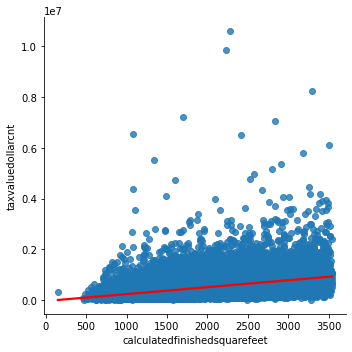

In [4]:
sns.lmplot(x='calculatedfinishedsquarefeet', y='taxvaluedollarcnt', data=train, line_kws={'color': 'red'})
plt.show()

Statistical Testing

Hypothesis:
- H0 = The square footage of the home is not related to its sale price

- Ha = The square footage of the home is related to its sale price

In [5]:
x = train.calculatedfinishedsquarefeet
y = train.taxvaluedollarcnt
corr, p = stats.pearsonr(x, y)
corr, p

(0.4250893179680343, 0.0)

##### Question 2: Is the year the home was built related to its sale price?

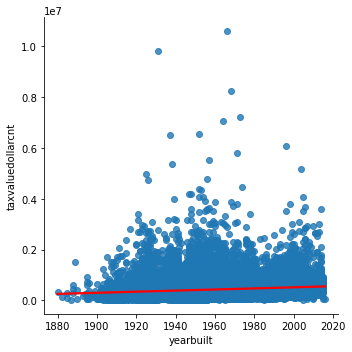

In [6]:
sns.lmplot(x='yearbuilt', y='taxvaluedollarcnt', data=train, line_kws={'color': 'red'})
plt.show()

Hypothesis:
- H0 = The year a home was built is not related to its sale price

- Ha = The year a home was built is related to its sale price

In [7]:
x = train.yearbuilt
y = train.taxvaluedollarcnt
corr, p = stats.pearsonr(x, y)
corr, p

(0.11712933672611295, 3.5249681304941167e-82)

##### Question 3: Is the number of bedrooms a home has related to its sale price ?

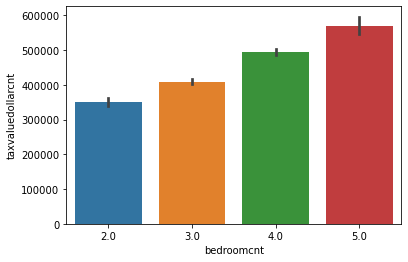

In [8]:
sns.barplot(x='bedroomcnt', y='taxvaluedollarcnt', data=train)
plt.show()

Hypothesis:
- H0 = The number of bedrooms a home has in not related to its sale price

- Ha = The number of bedrooms a home has is related to its sale price

In [9]:
x = train.bedroomcnt
y = train.taxvaluedollarcnt
corr, p = stats.pearsonr(x, y)
corr, p

(0.14557193107457012, 2.3661704502903452e-126)

##### Question 4: Is the number of bathrooms a home has related to its sale price?

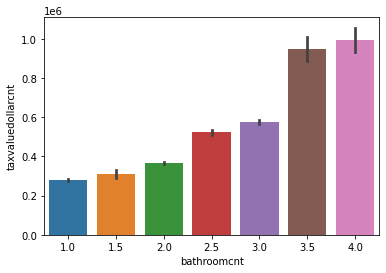

In [10]:
sns.barplot(x='bathroomcnt', y='taxvaluedollarcnt', data=train)
plt.show()

Hypothesis:
- H0 = The number of bathrooms a home has is not related to its sale price

- Ha = The number of bathrooms a house has is related to its sale price

In [11]:
x = train.bathroomcnt
y = train.taxvaluedollarcnt
corr, p = stats.pearsonr(x, y)
corr, p

(0.3551077216333759, 0.0)

---

#### Prepare the Dataset for Modeling
- After exploring the dataset with modeling and statistical testing it needed to be prepared for modeling with machine learning

- x and y variable were assigned for each of the split datasets with y representing the target variable of home price and x representing the features that will be used by the model to predict home price

- The x variables were scaled using a Min - Max scaler so that the model did not put extra weight on one variable over another due to the difference in ranges of values

- Each split dataset had the scaler applied to the x variables

In [12]:
#assign the x and y variables for the train dataset
x_train = train[['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'yearbuilt']]
y_train = train[['taxvaluedollarcnt']]
#assign the x and y variables for the validate dataset
x_validate = validate[['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'yearbuilt']]
y_validate = validate[['taxvaluedollarcnt']]
#assign the x and y variable for the test dataset
x_test = test[['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'yearbuilt']]
y_test = test[['taxvaluedollarcnt']]

#create a min-max scaler object
scaler = MinMaxScaler()
#fit the scaler object with the x_train data
scaler.fit(x_train)
#scale the x_train data and output a dataframe with the results
scaled_df = scaler.transform(x_train)
x_train_scaled = pd.DataFrame(scaled_df, columns=x_train.columns, index=x_train.index)
#scale the x_validate data and output a dataframe with the results
val_scaled_df = scaler.transform(x_validate)
x_validate_scaled = pd.DataFrame(val_scaled_df, columns=x_validate.columns, index=x_validate.index)
#scale the x_test data and output a dataframe with the results
test_scaled_df = scaler.transform(x_test)
x_test_scaled = pd.DataFrame(test_scaled_df, columns=x_test.columns, index=x_test.index)

---

##### Feature selection / ranking
- A recursive feature elimination model was used to evaluate which of the selected features were most related to the target variable and the results were used during model development

In [15]:
#assign the x and y variables to be used by the model
x = x_train_scaled
y = y_train
#create the relational model that the feature selection model will use to evaluate features
model = LinearRegression()
#create the feature selection model and fit it with the above assigned model and variables
rfe = RFE(model, n_features_to_select=1).fit(x, y)
#output the results as a dataframe
pd.DataFrame({'rfe_ranking': rfe.ranking_}, index=x.columns)

,rfe_ranking
bedroomcnt,2
bathroomcnt,4
calculatedfinishedsquarefeet,1
yearbuilt,3


---

##### Predictive modeling
- Multiple models with different features, multiple model types, and multiple model hyperparameters were created and evaluate during the project. The three best performing models are included below

- A predictions dataframe was created to enter the results from each model so they can be compared side by side

- Each model was fit / trained with the train dataset then predictions were made using the validate dataset to evaluate its performance

In [16]:
#create the predictions dataframe and fill the first column with the actual home sale prices from the validate dataset
#to evaluate the model's performance against
predictions = pd.DataFrame({'actual': validate.taxvaluedollarcnt})
#add a second column to the predictions dataframe that contains a baseline prediction 
#which is the mean of the actual sale prices in the validate dataset
predictions['baseline'] = validate.taxvaluedollarcnt.median()

In [17]:
## Model 1 - Multiple Regression Model##

#Create the regression model object
lm = LinearRegression()
#fit/train the model with the train dataset
lm.fit(x_train_scaled, y_train)
#add a column to the predictions dataframe that contains the resulting predictions of the multiple regression model
predictions['multiple_regression'] = lm.predict(x_validate_scaled)

In [18]:
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
poly.fit(x_train_scaled)
x_train_poly = pd.DataFrame(
    poly.transform(x_train_scaled),
    columns=poly.get_feature_names(x_train_scaled.columns),
    index=x_train_scaled.index,
)
poly_rm = LinearRegression()
poly_rm.fit(x_train_poly, y_train)

x_validate_poly = poly.transform(x_validate_scaled)
predictions['polynomial degree 2'] = poly_rm.predict(x_validate_poly)

In [19]:
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
poly.fit(x_train_scaled)
x_train_poly = pd.DataFrame(
    poly.transform(x_train_scaled),
    columns=poly.get_feature_names(x_train_scaled.columns),
    index=x_train_scaled.index,
)
lm = LinearRegression()
lm.fit(x_train_poly, y_train)

x_validate_poly = poly.transform(x_validate_scaled)
predictions['polynomial only interaction'] = lm.predict(x_validate_poly)

In [20]:
def calculate_mse(y_predicted):
    return mean_squared_error(predictions.actual, y_predicted)

predictions.apply(calculate_mse).apply(math.sqrt)

actual                              0.000000
baseline                       726686.739895
multiple_regression            580938.183527
polynomial degree 2            558677.387305
polynomial only interaction    550270.829353
dtype: float64

The best model reduced the error of home price prediction by $176,415.91 over baseline prediction (median home price) with the validate dataset

---

##### Evaluate the best model on the test data

In [21]:
test_predictions = pd.DataFrame({'actual': y_test.taxvaluedollarcnt})
test_predictions['baseline'] = y_test.taxvaluedollarcnt.median()

In [22]:
y_test.shape, x_test.shape

((10464, 1), (10464, 4))

In [23]:
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
poly.fit(x_train_scaled)
x_train_poly = pd.DataFrame(
    poly.transform(x_train_scaled),
    columns=poly.get_feature_names(x_train_scaled.columns),
    index=x_train_scaled.index,
)
lm = LinearRegression()
lm.fit(x_train_poly, y_train)

x_test_poly = poly.transform(x_test_scaled)
test_predictions['polynomial only interaction'] = lm.predict(x_test_poly)

In [24]:
def calculate_mse_test(y_predicted):
    return mean_squared_error(test_predictions.actual, y_predicted)

test_predictions.apply(calculate_mse_test).apply(math.sqrt)

actual                              0.000000
baseline                       737028.517255
polynomial only interaction    531542.036550
dtype: float64

The model reduced the error in home price prediction by $205,486.48 from the baseline predicted home price (median home price)

---

#### Improving Model Accuracy by Splitting the Dataset by Region
- After developing the above primary model that performed notably better than baseline and not being able to improve on that performance through the use of additional features or manipulation of hyperparameters other options for model improvement were explored

- During data exploration it was noted that the range of home prices were different between regions so we decided to explore seperating the dataset into three datasets based on region and run the best performing primary model on each seperately


In [2]:
#pull the dataset from the database using the acquire_zillow function in the acquire.py file
df = acquire_zillow()
#since we are only loosing 112 rows out of 52442 if we drop all the rows with null values, that is the approach I took
df = prep_data(df)

df1, df2, df3 = split_by_region(df)
df1.shape, df2.shape, df3.shape

Reading from csv file...


((33880, 6), (14082, 6), (4358, 6))

In [3]:
## Dataframe 1 - Homes in Los Angeles, CA

#split the data into train, validate, and test using the split_data function from the prepare.py file
train, validate, test = split_data(df1)
#assign the columns we want to remove outliers from to a variable that can be used with the function
out_columns = ['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet',]
#use the function from the prepare.py file to remove outliers from the train dataset
train = remove_outliers(train, 1.5, out_columns)

x_train = train[['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'yearbuilt']]
y_train = train[['taxvaluedollarcnt']]
x_validate = validate[['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'yearbuilt']]
y_validate = validate[['taxvaluedollarcnt']]

scaler = MinMaxScaler()
scaler.fit(x_train)

scaled_df = scaler.transform(x_train)
x_train_scaled = pd.DataFrame(scaled_df, columns=x_train.columns, index=x_train.index)

val_scaled_df = scaler.transform(x_validate)
x_validate_scaled = pd.DataFrame(val_scaled_df, columns=x_validate.columns, index=x_validate.index)

d1_predictions = pd.DataFrame({'actual': validate.taxvaluedollarcnt})
d1_predictions['baseline'] = validate.taxvaluedollarcnt.median()

poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
poly.fit(x_train_scaled)
x_train_poly = pd.DataFrame(
    poly.transform(x_train_scaled),
    columns=poly.get_feature_names(x_train_scaled.columns),
    index=x_train_scaled.index,
)
lm = LinearRegression()
lm.fit(x_train_poly, y_train)

x_validate_poly = poly.transform(x_validate_scaled)
d1_predictions['polynomial only interaction'] = lm.predict(x_validate_poly)

def calculate_mse_1(y_predicted):
    return mean_squared_error(d1_predictions.actual, y_predicted)


In [4]:
## Dataframe 2 - Homes in Orange County, CA

#split the data into train, validate, and test using the split_data function from the prepare.py file
train, validate, test = split_data(df2)
#assign the columns we want to remove outliers from to a variable that can be used with the function
out_columns = ['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet',]
#use the function from the prepare.py file to remove outliers from the train dataset
train = remove_outliers(train, 1.5, out_columns)

x_train = train[['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'yearbuilt']]
y_train = train[['taxvaluedollarcnt']]
x_validate = validate[['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'yearbuilt']]
y_validate = validate[['taxvaluedollarcnt']]

scaler = MinMaxScaler()
scaler.fit(x_train)
scaled_df = scaler.transform(x_train)
x_train_scaled = pd.DataFrame(scaled_df, columns=x_train.columns, index=x_train.index)
val_scaled_df = scaler.transform(x_validate)
x_validate_scaled = pd.DataFrame(val_scaled_df, columns=x_validate.columns, index=x_validate.index)

d2_predictions = pd.DataFrame({'actual': validate.taxvaluedollarcnt})
d2_predictions['baseline'] = validate.taxvaluedollarcnt.median()

poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
poly.fit(x_train_scaled)
x_train_poly = pd.DataFrame(
    poly.transform(x_train_scaled),
    columns=poly.get_feature_names(x_train_scaled.columns),
    index=x_train_scaled.index,
)
lm = LinearRegression()
lm.fit(x_train_poly, y_train)

x_validate_poly = poly.transform(x_validate_scaled)
d2_predictions['polynomial only interaction'] = lm.predict(x_validate_poly)

def calculate_mse_2(y_predicted):
    return mean_squared_error(d2_predictions.actual, y_predicted)


In [5]:
## Dataframe 3 - Homes in Ventura County, CA

#split the data into train, validate, and test using the split_data function from the prepare.py file
train, validate, test = split_data(df3)
#assign the columns we want to remove outliers from to a variable that can be used with the function
out_columns = ['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet',]
#use the function from the prepare.py file to remove outliers from the train dataset
train = remove_outliers(train, 1.5, out_columns)

x_train = train[['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'yearbuilt']]
y_train = train[['taxvaluedollarcnt']]
x_validate = validate[['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'yearbuilt']]
y_validate = validate[['taxvaluedollarcnt']]

scaler = MinMaxScaler()
scaler.fit(x_train)
scaled_df = scaler.transform(x_train)
x_train_scaled = pd.DataFrame(scaled_df, columns=x_train.columns, index=x_train.index)
val_scaled_df = scaler.transform(x_validate)
x_validate_scaled = pd.DataFrame(val_scaled_df, columns=x_validate.columns, index=x_validate.index)

d3_predictions = pd.DataFrame({'actual': validate.taxvaluedollarcnt})
d3_predictions['baseline'] = validate.taxvaluedollarcnt.median()

poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
poly.fit(x_train_scaled)
x_train_poly = pd.DataFrame(
    poly.transform(x_train_scaled),
    columns=poly.get_feature_names(x_train_scaled.columns),
    index=x_train_scaled.index,
)
lm = LinearRegression()
lm.fit(x_train_poly, y_train)

x_validate_poly = poly.transform(x_validate_scaled)
d3_predictions['polynomial only interaction'] = lm.predict(x_validate_poly)

def calculate_mse_3(y_predicted):
    return mean_squared_error(d3_predictions.actual, y_predicted)


In [6]:
print('Best model with the Los Angeles County, CA dataset:')
print('--------------------------------------------------')
print(d1_predictions.apply(calculate_mse_1).apply(math.sqrt))
print('==================================================')
print('')
print('Best model with the Orange County, CA dataset:')
print('--------------------------------------------------')
print(d2_predictions.apply(calculate_mse_2).apply(math.sqrt))
print('==================================================')
print('')
print('Best model with the Ventura County, CA dataset:')
print('--------------------------------------------------')
print(d3_predictions.apply(calculate_mse_3).apply(math.sqrt))
print('==================================================')

Best model with the Los Angeles County, CA dataset:
--------------------------------------------------
actual                              0.000000
baseline                       955202.869381
polynomial only interaction    589841.530967
dtype: float64

Best model with the Orange County, CA dataset:
--------------------------------------------------
actual                              0.000000
baseline                       606849.730866
polynomial only interaction    407707.437513
dtype: float64

Best model with the Ventura County, CA dataset:
--------------------------------------------------
actual                              0.000000
baseline                       621305.426458
polynomial only interaction    424779.037957
dtype: float64


After splitting the dataset by region, on average the model reduced the error in home price prediction by $253,676.67 from the baseline home price prediction (median home value) which is an improvement of 69.5% from the dataset not seperated by region

- Average of reduced error from baseline was used above to make the difference more comparable to the primary model in the notebook which did not split the dataset by region

- The model improvement percentage above is based on comparison of the split data models and the validate dataset predictions from the primary model because the split data predictions are done with the split validate datasets